In [98]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rcParams['font.family'] = 'serif'
plt.rc('font', size=16)

In [4]:
df_matches = pd.read_csv('./2020_Problem_D_DATA/matches.csv')
df_matches[:3]

,MatchID,OpponentID,Outcome,OwnScore,OpponentScore,Side,CoachID
0,1,Opponent1,win,1,0,home,Coach1
1,2,Opponent2,tie,1,1,away,Coach1
2,3,Opponent3,loss,0,2,away,Coach1


In [6]:
# types of events
set(df_huskies['EventType'].values)

{'Duel',
 'Foul',
 'Free Kick',
 'Goalkeeper leaving line',
 'Interruption',
 'Offside',
 'Others on the ball',
 'Pass',
 'Save attempt',
 'Shot',
 'Substitution'}

# 8 classical football metrics

## (A) number of passes

In [42]:
df_pass = pd.read_csv('./2020_Problem_D_DATA/passingevents.csv')
pass_huskies = df_pass[df_pass['TeamID'] == 'Huskies']
huskies_pass = pass_huskies.groupby('MatchID')['TeamID'].count().values

pass_opponent = df_pass[df_pass['TeamID'] != 'Huskies']
opponent_pass = pass_opponent.groupby('MatchID')['TeamID'].count().values

df_matches['Huskies_pass'] = huskies_pass
df_matches['Opponent_pass'] = opponent_pass

df_match_pass = df_matches.groupby('OpponentID')[['Huskies_pass', 'Opponent_pass']].sum()
df_match_pass.to_csv('Passes.csv')
df_match_pass[:3]

,Huskies_pass,Opponent_pass
OpponentID,,
Opponent1,698,412
Opponent10,608,487
Opponent11,421,577


## (B) number of shots

In [43]:
df = pd.read_csv('./2020_Problem_D_DATA/fullevents.csv')
df_huskies = df[df['TeamID'] == 'Huskies']
df_opponents = df[df['TeamID'] != 'Huskies']

# Huskies队在所有场的比赛中射门次数
huskies_shot = df_huskies[df_huskies['EventType'] == 'Shot'].groupby('MatchID')['TeamID'].count().values

# Opponent某队在所有场的比赛中射门次数（每场的队不一样）
opponent_shot = df_opponents[df_opponents['EventType'] == 'Shot'].groupby('MatchID')['TeamID'].count().values

df_matches['Huskies_shot'] = huskies_shot
df_matches['Opponent_shot'] = opponent_shot

df_shots = df_matches.groupby('OpponentID')[['Huskies_shot', 'Opponent_shot']].sum()
df_shots.to_csv('./Shots.csv')
df_shots[:3]

,Huskies_shot,Opponent_shot
OpponentID,,
Opponent1,23,20
Opponent10,24,13
Opponent11,12,22


## (C) number of goals

In [45]:
df_goals = df_matches.groupby('OpponentID')[['OwnScore','OpponentScore']].sum()
df_goals = df_goals.rename(columns={"OwnScore": "Huskies_score", "OpponentScore": "Opponent_score"})
df_goals.to_csv('./Goals.csv')
df_goals[:3]

,Huskies_score,Opponent_score
OpponentID,,
Opponent1,3,1
Opponent10,2,3
Opponent11,3,3


## (D) number of points

## (E) average of X

In [46]:
def cal_mean_position(direction):
    huskies_coor = df_pass[df_pass['TeamID'] == 'Huskies']
    opponent_coor = df_pass[df_pass['TeamID'] != 'Huskies']

    huskies_coor_match = huskies_coor.groupby('MatchID')['EventOrigin_{}'.format(direction)].mean()
    opponent_coor_match = opponent_coor.groupby('MatchID')['EventOrigin_{}'.format(direction)].mean()

    df_matches['Huskies_{}'.format(direction)] = huskies_coor_match.values # 注意这里要用.values赋值，否则第零行是空的
    df_matches['Opponent_{}'.format(direction)] = opponent_coor_match.values

    huskies_coor_id = df_matches.groupby('OpponentID')['Huskies_{}'.format(direction)].mean()
    opponent_coor_id = df_matches.groupby('OpponentID')['Opponent_{}'.format(direction)].mean()
    
    return huskies_coor_id, opponent_coor_id

huskies_x_id, opponent_x_id = cal_mean_position(direction='x')

In [54]:
df_coor_x = pd.DataFrame([huskies_x_id, opponent_x_id]).T
df_coor_x.to_csv('Coorx.csv')
df_coor_x[:3]

,Huskies_x,Opponent_x
OpponentID,,
Opponent1,46.754903,49.039759
Opponent10,49.496303,43.027524
Opponent11,47.010321,49.439481


## (F) average of Y

In [55]:
huskies_y_id, opponent_y_id = cal_mean_position(direction='y')

df_coor_y = pd.DataFrame([huskies_y_id, opponent_y_id]).T
df_coor_y.to_csv('Coory.csv')
df_coor_y[:3]

,Huskies_y,Opponent_y
OpponentID,,
Opponent1,52.911080,47.271845
Opponent10,52.208544,47.740218
Opponent11,51.573483,52.197889


## (G) dispersion

In [72]:
h_coor_match = pd.merge(pass_huskies, df_matches, how='left', on='MatchID')
h_coor_match['Distance'] = np.sqrt(np.square(h_coor_match['EventOrigin_x'] - h_coor_match['Huskies_x']) + \
                                   np.square(h_coor_match['EventOrigin_y'] - h_coor_match['Huskies_y']))

h_dispersion_match = h_coor_match.groupby('MatchID')['Distance'].std(ddof=1).values
df_matches['Huskies_dispersion'] = h_dispersion_match
h_dispersion_id = df_matches.groupby('OpponentID')['Huskies_dispersion'].mean()

In [73]:
o_coor_match = pd.merge(pass_opponent, df_matches, how='left', on='MatchID')
o_coor_match['Distance'] = np.sqrt(np.square(o_coor_match['EventOrigin_x'] - o_coor_match['Opponent_x']) + \
                                   np.square(o_coor_match['EventOrigin_y'] - o_coor_match['Opponent_y']))

o_dispersion_match = o_coor_match.groupby('MatchID')['Distance'].std(ddof=1).values
df_matches['Opponent_dispersion'] = o_dispersion_match
o_dispersion_id = df_matches.groupby('OpponentID')['Opponent_dispersion'].mean()

In [74]:
df_dispersion = pd.DataFrame([h_dispersion_id, o_dispersion_id]).T
df_dispersion.to_csv('Dispersion.csv')
df_dispersion[:3]

,Huskies_dispersion,Opponent_dispersion
OpponentID,,
Opponent1,13.992035,12.284797
Opponent10,11.894599,13.209759
Opponent11,14.168883,12.697066


## (H) advance ratio

In [77]:
h_coor_match['Delta_x'] = np.abs(h_coor_match['EventDestination_x'] - h_coor_match['EventOrigin_x'])
h_coor_match['Delta_y'] = np.abs(h_coor_match['EventDestination_y'] - h_coor_match['EventOrigin_y'])
h_dx_match = h_coor_match.groupby('MatchID')['Delta_x'].sum().values
h_dy_match = h_coor_match.groupby('MatchID')['Delta_y'].sum().values
df_matches['Huskies_ratio'] = h_dy_match / h_dx_match

In [78]:
o_coor_match['Delta_x'] = np.abs(o_coor_match['EventDestination_x'] - o_coor_match['EventOrigin_x'])
o_coor_match['Delta_y'] = np.abs(o_coor_match['EventDestination_y'] - o_coor_match['EventOrigin_y'])
o_dx_match = o_coor_match.groupby('MatchID')['Delta_x'].sum().values
o_dy_match = o_coor_match.groupby('MatchID')['Delta_y'].sum().values
df_matches['Opponent_ratio'] = o_dy_match / o_dx_match

In [79]:
h_ratio_id = df_matches.groupby('OpponentID')['Huskies_ratio'].mean()
o_ratio_id = df_matches.groupby('OpponentID')['Opponent_ratio'].mean()

In [80]:
Ratio = pd.merge(h_ratio_id, o_ratio_id, how='left', on='OpponentID')
Ratio.to_csv('AdvanceRatio.csv')
Ratio

,Huskies_ratio,Opponent_ratio
OpponentID,,
Opponent1,2.044927,1.450086
Opponent10,1.452312,1.471001
Opponent11,1.450814,1.600366
Opponent12,1.644212,1.464643
Opponent13,1.608704,1.807067
Opponent14,1.533365,1.706565
Opponent15,1.274068,1.707571
Opponent16,1.401205,1.811766
Opponent17,1.632852,1.452246


# Plot

In [87]:
def calc_mean_std(x):
    return (np.mean(x), np.std(x, ddof=1) / np.sqrt(len(x)))

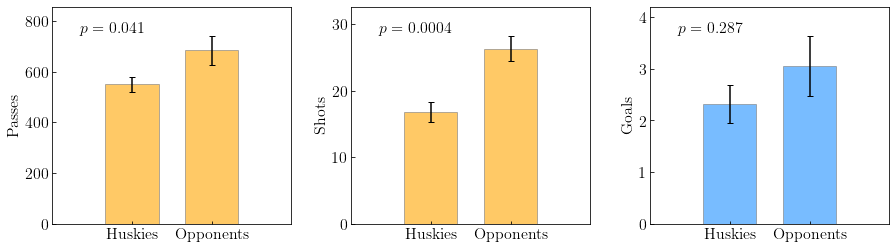

In [120]:
### overall
from scipy import stats
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

file_set = ['Passes', 'Shots', 'Goals']
column_names = ['_pass', '_shot', '_score']
ylabel_set = ['Passes', 'Shots', 'Goals']
color_dict = {True: 'orange', False: 'dodgerblue'}

for ind in range(3):
    ax = axes[ind % 3]
    
    df = pd.read_csv(file_set[ind] + '.csv')
    column = column_names[ind]
    
    huskie = calc_mean_std(df['Huskies' + column]) 
    oppo = calc_mean_std(df['Opponent' + column])
    
    levene = stats.levene(df['Huskies' + column].values, df['Opponent' + column].values)
    ttest = stats.ttest_ind(df['Huskies' + column].values, 
                            df['Opponent' + column].values, 
                            equal_var=(levene.pvalue > 0.05))
    pvalue = ttest.pvalue
    
    x_label = ['Huskies', 'Opponents']
    x_pos = [1.5, 3.0]
    
    ax.bar(x_pos, [huskie[0], oppo[0]], 
           yerr=[huskie[1], oppo[1]], 
           error_kw={'capsize': 3}, 
           width=1, color=color_dict[pvalue < 0.05], 
           edgecolor='gray',
           alpha=0.6)
    ylim = ax.get_ylim()
    if ind == 1:
        ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.03, r'$p={:.4f}$'.format(pvalue))
    else:
        ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.03, r'$p={:.3f}$'.format(pvalue))
    ax.set_xlim(0, 4.5)
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label)
    ax.set_ylabel(ylabel_set[ind])
    ax.tick_params(direction='in')
    
plt.subplots_adjust(wspace=0.25)

plt.savefig('./pass_shot_goal.png', dpi=200, bbox_inches='tight')
plt.savefig('./pass_shot_goal.pdf', dpi=200, bbox_inches='tight')

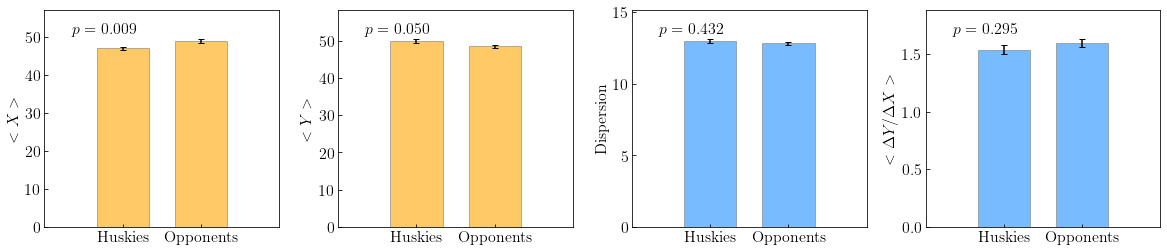

In [121]:
### Structual
from scipy import stats
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

file_set = ['Coorx', 'Coory', 'Dispersion', 'AdvanceRatio']
column_names = ['_x', '_y', '_dispersion', '_ratio']
ylabel_set = [r'$<X>$', r'$<Y>$', 'Dispersion', r'$<\Delta Y>/<\Delta X>$']
color_dict = {True: 'orange', False: 'dodgerblue'}

for ind in range(4):
    ax = axes[ind % 4]
    
    df = pd.read_csv(file_set[ind] + '.csv')
    column = column_names[ind]
    
    huskie = calc_mean_std(df['Huskies' + column]) 
    oppo = calc_mean_std(df['Opponent' + column])
    
    levene = stats.levene(df['Huskies' + column].values, df['Opponent' + column].values)
    ttest = stats.ttest_ind(df['Huskies' + column].values, 
                            df['Opponent' + column].values, 
                            equal_var=(levene.pvalue > 0.05))
    pvalue = ttest.pvalue
    
    x_label = ['Huskies', 'Opponents']
    x_pos = [1.5, 3.0]
    
    ax.bar(x_pos, [huskie[0], oppo[0]], 
           yerr=[huskie[1], oppo[1]], 
           error_kw={'capsize': 3}, 
           width=1, color=color_dict[pvalue < 0.05], 
           edgecolor='gray',
           alpha=0.6)
    ylim = ax.get_ylim()
    ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.02, r'$p={:.3f}$'.format(pvalue))
    ax.set_xlim(0, 4.5)
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label)
    ax.set_ylabel(ylabel_set[ind])
    ax.tick_params(direction='in')
    
plt.subplots_adjust(wspace=0.25)

plt.savefig('./spatial_structure.png', dpi=200, bbox_inches='tight')
plt.savefig('./spatial_structure.pdf', dpi=200, bbox_inches='tight')